In [28]:
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [29]:
dataframe = pandas.read_csv("dataset.csv").dropna()
feature_names = ["Appliances","T1","RH_1","T2","RH_2","T3","RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7","RH_7","T8","RH_8","T9","RH_9","T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint"]
dataframe = dataframe[feature_names]

X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = (1 / 3)
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [ ]:
performance = {}
N_ESTIMATORS = 5000
for max_depth_iterator in [1, 2, 3]:
    print("max_depth: %d" %max_depth_iterator)
    performance[max_depth_iterator] = [0] * N_ESTIMATORS
    gradient_boosting_regressor = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = N_ESTIMATORS, max_depth = max_depth_iterator, verbose = 1)
    gradient_boosting_regressor.fit(X_train, y_train)
    for ilteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(X)):
        performance[max_depth_iterator][ilteration] = gradient_boosting_regressor.loss_(y, y_pred)
from pathlib import Path  

csv_string = ""
gradient_boosted_graph_metrics_dataset_path_string = "./GBR_graph_metrics_dataset.csv"
for depth in performance.keys():
    for ilteration in numpy.arange(len(performance[depth])):
        csv_string = csv_string + "\n" + str(depth) + "," + str(ilteration) + "," + str(performance[depth][ilteration])
gradient_boosted_graph_metrics_dataset = open("./GBR_graph_metrics_dataset.csv", "w")
gradient_boosted_graph_metrics_dataset.write(csv_string)
gradient_boosted_graph_metrics_dataset.close()

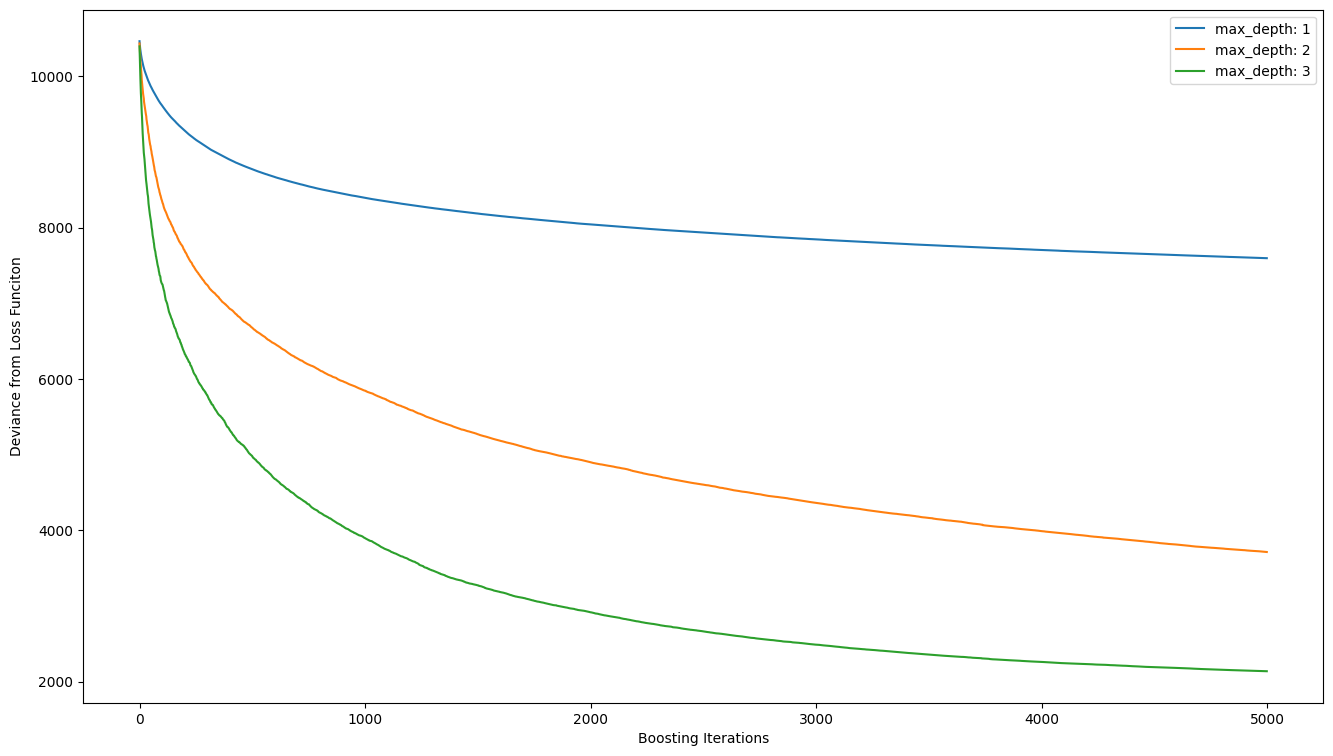

In [84]:
plot.figure(figsize=(16,9))
plot.xlabel('Boosting Iterations')
plot.ylabel('Deviance from Loss Funciton')
for depth in performance.keys():
    plot.plot(numpy.arange(len(performance[depth])), performance[depth], label = "max_depth: "  + str(depth))
plot.legend(loc='upper right')

plot.savefig("GBR_deviation_vs_ilteration_for_multiple_max_depth.png")
plot.show()